# Metric Calculation
Calculate metrics for models run on the full dataset

## Imports and Data Loading

In [112]:
import xgboost
from xgboost import plot_importance
from bgpredict.helpers import S3Connection
from dotenv import load_dotenv
import multiprocessing
import json
import os
import numpy as np
import pandas as pd
from dotenv import load_dotenv
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
import sqlalchemy
from sqlalchemy import create_engine
from datetime import datetime
from skopt import BayesSearchCV, dump, load
from skopt.plots import plot_objective, plot_histogram
from s3fs.core import S3FileSystem
import matplotlib.pyplot as plt 

In [113]:
os.chdir('../')
load_dotenv()
os.chdir('./Baseline')

In [114]:
def clean_data(df):
    # Drop rows with no Y value
    df = df.dropna(subset='bg')

    # Fill nulls (lag BG values) with 0 to indicate data is unavailable
    print(f"Null values to be filled by column:")
    nulls = df.isna().sum()
    null_idx = list(nulls.index)
    vals = list(nulls)
    for col, val in list(zip(null_idx, vals)):
        if val > 0:
            print(col, val)
    df = df.fillna(0)

    # Sort by timestamp
    current_len = len(df)
    df = df.loc[~(df['timestamp_clean'].apply(type) == int), :]
    print(f"Dropping {current_len - len(df)} invalid timestamps")
    df = df.sort_values(by="timestamp_clean")

    # Set index to time_stamp_clean
    df.index = df['timestamp_clean']
    df = df.drop(labels=['timestamp_clean'], axis=1)

    # Drop first row by subject which has data quality issues
    df = df[df.groupby('subjectid').cumcount() > 0]

    # Drop columns that are indices, irrelevant, or capture in OHE variables
    drop_cols = ['timestamp', 'date', 'time']
    df = df.drop(labels=drop_cols, axis=1)

    # One hot Encode Weekdays
    weekdays = np.unique(df['weekday'])
    ohe_weekdays = [f"ohe_{day}" for day in weekdays]
    df[ohe_weekdays] = pd.get_dummies(df.weekday)
    df = df.drop(labels="weekday", axis=1)

    return df

In [6]:
location = f"postgresql://postgres:{os.environ.get('db_password')}@{os.environ.get('db_location')}"
engine = create_engine(location)
conn = engine.connect()
raw_df = pd.read_sql("select * from public.vw_final_dataset where test_set = 1", conn)
clean_df = clean_data(raw_df)

Null values to be filled by column:
bg_lag_1 6593
bg_lag_2 6449
bg_lag_3 6420
bg_lag_4 6548
bg_lag_5 6614
bg_lag_6 6577
bg_lag_7 6653
bg_lag_8 6720
bg_lag_9 6683
bg_lag_10 6694
bg_lag_11 6746
bg_lag_12 6758
Dropping 0 invalid timestamps


In [7]:
s3_conn = S3Connection()

## Helper Funcs

In [8]:
def graph_metrics(model_type, overall_metrics, by_subject_metrics, text_y):
    fig, axs = plt.subplots(1,3, sharey=True, figsize=(15,3))
    for idx, key in enumerate(by_subject_metrics):
        ax = axs[idx]
        ax.hist(by_subject_metrics[key], bins=100)
        ax.set_title(f"{key.upper()}")
        overall_metric = overall_metrics[key]
        vertical_line = ax.axvline(overall_metric, color='red', label=f'Test {key.upper()}')
        ax.text(x = overall_metric+ 0.01 * ax.get_xlim()[1], y=text_y, s=np.round(overall_metric, 2))
        x_coord = vertical_line.get_xdata()[1]
        ax.legend()
        ax.set_xlabel(f"{key.upper()}")
        plt.suptitle('ARIMA Evaluation Metrics by Subject', y=1.15, fontsize=15)
        plt.title('Root Mean Square Error (RMSE), Mean Absolute Error (MAE), and Mean Absolute Prediction Error (MAPE)',
                  x=0.5, transform=fig.transFigure, fontsize=12)
        fig.supylabel("Subject Count", x=0.08)

## Arima

In [9]:
arima_locs = s3_conn.s3_client.list_objects_v2(Bucket=s3_conn.bucket_name, Prefix="models/arima/")
arima_locs['Contents']
result_uris = []
for x in arima_locs["Contents"]:
    path = x['Key']
    if "results" in path:
        uri = f"s3://{s3_conn.bucket_name}/{path}"
        result_uris.append(uri)
result_dfs= []
for uri in result_uris:
    df = pd.read_csv(uri)
    df.columns = ['subjectid', 'entryid', 'y', 'y_hat']
    result_dfs.append(df)
result_dfs[0].head()

,subjectid,entryid,y,y_hat
0,12689381,575,154.0,145.398916
1,12689381,574,147.0,147.389779
2,12689381,573,140.0,148.096161
3,12689381,572,134.0,147.715828
4,12689381,571,130.0,146.491036


In [10]:
arima_df = pd.concat(result_dfs)

# There are 162 rows where y == 0 which artificially inflates MAPE
arima_df = arima_df.loc[arima_df['y'] != 0,:]
print(arima_df.shape)

(1253986, 4)


In [11]:
test = arima_df.loc[arima_df['y_hat'] > 1000, :]
erroneous_subject =np.unique(test['subjectid'])[0]
print(erroneous_subject)
test.describe()

93839818


,subjectid,entryid,y,y_hat
count,13508.0,13508.000000,13508.000000,13508.000000
mean,93839818.0,201722.300933,120.995114,1932.249169
std,0.0,8532.815657,54.468599,538.248621
min,93839818.0,187136.000000,38.000000,1000.078731
25%,93839818.0,194159.500000,83.000000,1466.163950
50%,93839818.0,202201.000000,110.000000,1932.249169
75%,93839818.0,209226.500000,147.000000,2398.334388
max,93839818.0,216135.000000,400.000000,2864.419607


Subject 93839818's predictions are erroneous. Drop this subject when evaluating ARIMA metrics.

In [12]:
arima_df = arima_df.loc[arima_df['subjectid'] != erroneous_subject]

In [13]:
full_mse = mean_squared_error(arima_df['y'], arima_df['y_hat'])
full_rmse = np.sqrt(full_mse)
full_mae = mean_absolute_error(arima_df['y'], arima_df['y_hat'])
full_mape = mean_absolute_percentage_error(arima_df['y'], arima_df['y_hat'])
print(f'MSE: {full_mse}')
print(f'RMSE: {full_rmse}')
print(f'MAE: {full_mae}')
print(f'MAPE: {full_mape}')
full_metrics = {'rmse':full_rmse, "mae": full_mae, "mape": full_mape}

MSE: 8117.6496236625935
RMSE: 90.09800010911782
MAE: 57.78072210054919
MAPE: 0.5339585423736942


In [14]:
metrics = {'rmse':[], "mae": [], "mape": []}
grouped = arima_df.groupby('subjectid')
for name, group in grouped:
    mse = mean_squared_error(group['y'], group['y_hat'])
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(group['y'], group['y_hat'])
    mape = mean_absolute_percentage_error(group['y'], group['y_hat'])
    metrics['rmse'].append(rmse)
    metrics['mae'].append(mae)
    metrics['mape'].append(mape)

In [15]:
def graph_metrics(model_type, overall_metrics, by_subject_metrics, text_y):
    fig, axs = plt.subplots(1,3, sharey=True, figsize=(15,3))
    for idx, key in enumerate(by_subject_metrics):
        ax = axs[idx]
        ax.hist(by_subject_metrics[key], bins=100)
        ax.set_title(f"{key.upper()}")
        overall_metric = overall_metrics[key]
        vertical_line = ax.axvline(overall_metric, color='red', label=f'Test {key.upper()}')
        ax.text(x = overall_metric+ 0.01 * ax.get_xlim()[1], y=text_y, s=np.round(overall_metric, 2))
        x_coord = vertical_line.get_xdata()[1]
        ax.legend()
        ax.set_xlabel(f"{key.upper()}")
    _ = plt.suptitle('ARIMA Evaluation Metrics by Subject', y=1.15, fontsize=15)
    _ = plt.title('Root Mean Square Error (RMSE), Mean Absolute Error (MAE), and Mean Absolute Prediction Error (MAPE)',
                  x=0.5, transform=fig.transFigure, fontsize=12)
    _ = fig.supylabel("Subject Count", x=0.08)

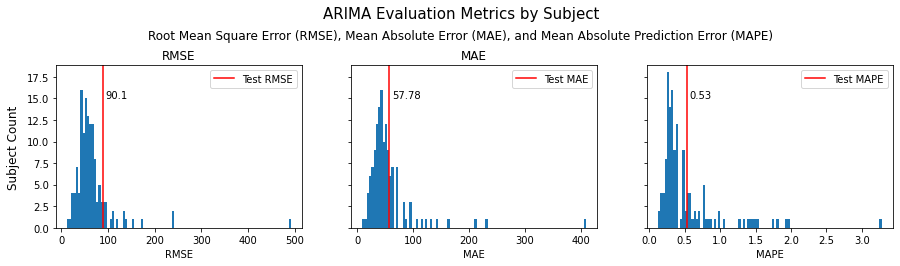

In [16]:
graph_metrics("ARIMA", full_metrics, metrics, 15)

(-100.0, 600.0)

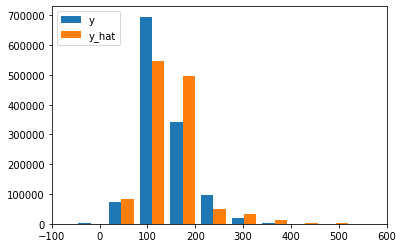

In [17]:
# _ = plt.hist(arima_df['y_hat'], bins=20, color='red')
_ = plt.hist([arima_df['y'], arima_df['y_hat']], bins=20, label = ['y', 'y_hat'])
plt.legend(loc="upper left")
plt.xlim(-100, 600)

## XGBoost

### XGBoost Load

In [18]:
model_loc =  "models/xgboost/02.11.36.475845_L4607592"

In [19]:
fs = S3FileSystem()
bst = xgboost.XGBRegressor()

path = "./model.json"
with fs.open(f"bgpredict/{model_loc}", 'rb') as f:
    bst.load_model(bytearray(f.read()))

### XGBoost Feature Importance

In [20]:
gain = bst.get_booster().get_score(importance_type='gain')
covers = bst.get_booster().get_score(importance_type='cover')
freq = bst.get_booster().get_score(importance_type='weight')

In [21]:
importances = list(zip(bst.feature_names_in_, bst.feature_importances_))
weekday = 0
subjectid = 0 
other = []
for x in importances:
    if 'ohe' in x[0]:
        indicator = x[0].split("_")[1]
        try:
            int(indicator)
            subjectid += x[1]
        except:
            weekday += x[1]
    else:
        key = x[0]
        if key == "normalized_carbs_datapercentile":
            k = "Carb Data Rank"
        elif key == "normalized_insulin_datapercentile":
            k = "Insulin Data Rank"
        elif key == "carbs_datacount":
            k = "Recorded Carb Count"
        elif key == "insulin_datacount":
            k = "Recorded Insulin Count"
        elif key == "datediff_currentbg_lastbg_inseconds":
            k = "Time Since Last BG"
        else:
            k = key.replace("_", " ")
        
        other.append((k, x[1]))
other.append(("Weekday Effects", weekday))
other.append(("Subject Effects", subjectid))
other.sort(key=lambda x: x[1])
# other

Text(0.5, 1.0, 'XGBoost Feature Importance')

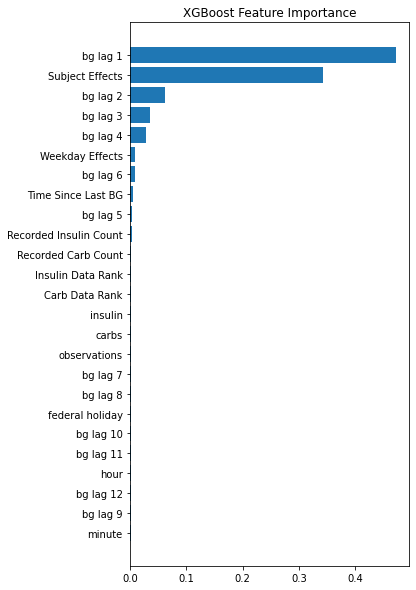

In [22]:
fig, ax = plt.subplots(figsize=(5, 10))
ax.barh(y=[x[0] for x in other], width=[x[1] for x in other])
plt.title("XGBoost Feature Importance")

### XGBoost Metrics

In [23]:
drop_cols = ['train_set', 'validation_set', 'test_set', 'subjectid', 'entryid', 'bg']
pred_df = clean_df.drop(drop_cols, axis=1)
preds = bst.predict(pred_df)

In [24]:
clean_df.loc[: , ['subjectid', 'entryid', 'bg']].reset_index()

,timestamp_clean,subjectid,entryid,bg
0,2016-08-10 00:43:50.664,68267781,43948,196.0
1,2016-08-10 00:48:51.032,68267781,43947,197.0
2,2016-08-10 01:13:49.950,68267781,43942,184.0
3,2016-08-10 01:23:49.686,68267781,43940,179.0
4,2016-08-10 01:33:50.462,68267781,43938,162.0
...,...,...,...,...
1305550,2021-03-18 23:36:58.983,56958831,29697,132.0
1305551,2021-03-18 23:41:59.650,56958831,29696,129.0
1305552,2021-03-18 23:46:58.908,56958831,29695,122.0
1305553,2021-03-18 23:51:59.718,56958831,29694,120.0


In [25]:
y_hat = pd.Series(preds, name='y_hat')
dfs = [clean_df.loc[:, ['subjectid', 'entryid', 'bg']].reset_index(drop=True), y_hat]
xgboost_df = pd.concat(dfs, axis=1, ignore_index=True)
xgboost_df.columns = ["subjectid", "entryid", "y", "y_hat"]
# Drop 162 0 values which artificially inflate MAPE 
xgboost_df = xgboost_df.loc[ xgboost_df['y'] !=0, :]
xgboost_df.head()

,subjectid,entryid,y,y_hat
0,68267781,43948,196.0,182.471954
1,68267781,43947,197.0,192.619751
2,68267781,43942,184.0,191.927048
3,68267781,43940,179.0,177.449188
4,68267781,43938,162.0,172.775406


In [26]:
full_mse = mean_squared_error(xgboost_df['y'], xgboost_df['y_hat'])
full_rmse = np.sqrt(full_mse)
full_mae = mean_absolute_error(xgboost_df['y'], xgboost_df['y_hat'])
full_mape = mean_absolute_percentage_error(xgboost_df['y'], xgboost_df['y_hat'])
print(f'MSE: {full_mse}')
print(f'RMSE: {full_rmse}')
print(f'MAE: {full_mae}')
print(f'MAPE: {full_mape}')
full_metrics = {'rmse':full_rmse, "mae": full_mae, "mape": full_mape}

MSE: 129.37372673948317
RMSE: 11.374257195064791
MAE: 5.166898947717827
MAPE: 0.05514040372229424


In [27]:
metrics = {'rmse':[], "mae": [], "mape": []}
grouped = xgboost_df.groupby('subjectid')
for name, group in grouped:
    mse = mean_squared_error(group['y'], group['y_hat'])
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(group['y'], group['y_hat'])
    mape = mean_absolute_percentage_error(group['y'], group['y_hat'])
    if mape >1000:
        print(group['subjectid'].iloc[0])
    metrics['rmse'].append(rmse)
    metrics['mae'].append(mae)
    metrics['mape'].append(mape)

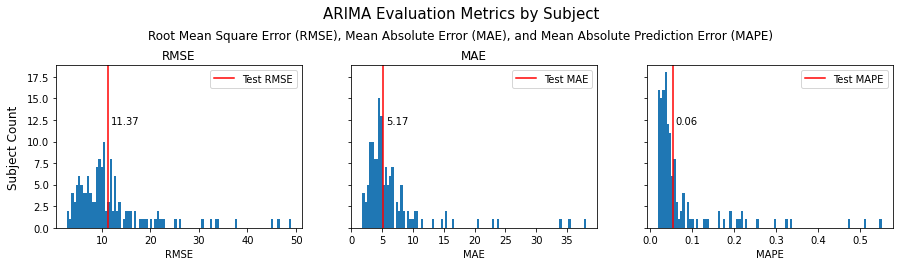

In [28]:
graph_metrics("XGBoost", full_metrics, metrics, 12)

In [29]:
test = []
for name, group in grouped:
    mse = mean_squared_error(group['y'], group['y_hat'])
    rmse = np.sqrt(mse)
#     mae = mean_absolute_error(group['y'], group['y_hat'])
#     mape = mean_absolute_percentage_error(group['y'], group['y_hat'])
    std_dev = np.std(group['y'])
#     print(std_dev)
    test.append((rmse, std_dev))
    

In [30]:
from sklearn.linear_model import LinearRegression

In [31]:
rmse = np.array([x[0] for x in test])
std_dev = np.array([x[1] for x in test]).reshape(-1,1)
regressor = LinearRegression()
regressor.fit(X=std_dev, y=rmse)
preds = regressor.predict(std_dev)

In [32]:
regression_line = [float(regressor.intercept_ + i * regressor.coef_) for i in range(90)]

In [33]:
r_sq = r2_score(rmse, preds)
r_sq

0.1605490998182152

Text(0.5, 1.0, 'R^2 = 0.16')

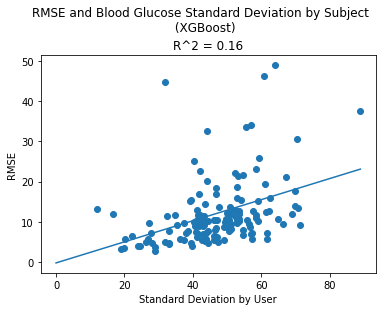

In [34]:
plt.scatter([x[1] for x in test], [x[0] for x in test])
plt.ylabel("RMSE")
plt.xlabel("Standard Deviation by User")
plt.plot(regression_line)
plt.suptitle("RMSE and Blood Glucose Standard Deviation by Subject \n (XGBoost)", y=1.05)
plt.title(f"R^2 = {np.round(r_sq, 2)}")

### Predict Forward

In [35]:
clean_df.head()

,subjectid,entryid,train_set,test_set,validation_set,ohe_221634,ohe_309157,ohe_897741,ohe_1352464,ohe_2033176,...,carbs_datacount,normalized_carbs_datapercentile,normalized_insulin_datapercentile,ohe_Friday,ohe_Monday,ohe_Saturday,ohe_Sunday,ohe_Thursday,ohe_Tuesday,ohe_Wednesday
timestamp_clean,,,,,,,,,,,,,,,,,,,,,
2016-08-10 00:43:50.664,68267781,43948,0,1,0,0,0,0,0,0,...,500,0.471429,0.521429,0,0,0,0,0,0,1
2016-08-10 00:48:51.032,68267781,43947,0,1,0,0,0,0,0,0,...,500,0.471429,0.521429,0,0,0,0,0,0,1
2016-08-10 01:13:49.950,68267781,43942,0,1,0,0,0,0,0,0,...,500,0.471429,0.521429,0,0,0,0,0,0,1
2016-08-10 01:23:49.686,68267781,43940,0,1,0,0,0,0,0,0,...,500,0.471429,0.521429,0,0,0,0,0,0,1
2016-08-10 01:33:50.462,68267781,43938,0,1,0,0,0,0,0,0,...,500,0.471429,0.521429,0,0,0,0,0,0,1


In [36]:
# group by subject
# sort by timestamp
# for row, predict i
groups = clean_df.groupby('subjectid')
# for name, group in groups:
#     group.sort_values(by=group.index)
#     print(name)
test = groups.get_group(309157)
test=test.sort_index()    
test['bg']

timestamp_clean
2019-06-08 00:07:20    101.0
2019-06-08 00:12:19     99.0
2019-06-08 00:17:20     94.0
2019-06-08 00:22:20     88.0
2019-06-08 00:27:20     82.0
                       ...  
2019-07-19 23:35:57    153.0
2019-07-19 23:40:57    154.0
2019-07-19 23:45:57    159.0
2019-07-19 23:50:57    162.0
2019-07-19 23:55:58    164.0
Name: bg, Length: 11942, dtype: float64

In [37]:
test = groups.get_group(309157)
test = test.sort_index()
test = test.reset_index()
shifts = pd.DataFrame({f"bg_future_{i}": test['bg'].shift(-i) for i in range(1,13)})
print(shifts.shape, test.shape)
shifts.head(12)

(11942, 12) (11942, 178)


,bg_future_1,bg_future_2,bg_future_3,bg_future_4,bg_future_5,bg_future_6,bg_future_7,bg_future_8,bg_future_9,bg_future_10,bg_future_11,bg_future_12
0,99.0,94.0,88.0,82.0,77.0,75.0,75.0,76.0,85.0,97.0,105.0,108.0
1,94.0,88.0,82.0,77.0,75.0,75.0,76.0,85.0,97.0,105.0,108.0,110.0
2,88.0,82.0,77.0,75.0,75.0,76.0,85.0,97.0,105.0,108.0,110.0,109.0
3,82.0,77.0,75.0,75.0,76.0,85.0,97.0,105.0,108.0,110.0,109.0,105.0
4,77.0,75.0,75.0,76.0,85.0,97.0,105.0,108.0,110.0,109.0,105.0,105.0
5,75.0,75.0,76.0,85.0,97.0,105.0,108.0,110.0,109.0,105.0,105.0,105.0
6,75.0,76.0,85.0,97.0,105.0,108.0,110.0,109.0,105.0,105.0,105.0,103.0
7,76.0,85.0,97.0,105.0,108.0,110.0,109.0,105.0,105.0,105.0,103.0,104.0
8,85.0,97.0,105.0,108.0,110.0,109.0,105.0,105.0,105.0,103.0,104.0,104.0
9,97.0,105.0,108.0,110.0,109.0,105.0,105.0,105.0,103.0,104.0,104.0,101.0


In [38]:
original = test[["subjectid", "entryid", 'bg']]
original.head()

,subjectid,entryid,bg
0,309157,48686,101.0
1,309157,48684,99.0
2,309157,48682,94.0
3,309157,48680,88.0
4,309157,48678,82.0


In [39]:
original.merge(shifts, left_index=True, right_index=True)

,subjectid,entryid,bg,bg_future_1,bg_future_2,bg_future_3,bg_future_4,bg_future_5,bg_future_6,bg_future_7,bg_future_8,bg_future_9,bg_future_10,bg_future_11,bg_future_12
0,309157,48686,101.0,99.0,94.0,88.0,82.0,77.0,75.0,75.0,76.0,85.0,97.0,105.0,108.0
1,309157,48684,99.0,94.0,88.0,82.0,77.0,75.0,75.0,76.0,85.0,97.0,105.0,108.0,110.0
2,309157,48682,94.0,88.0,82.0,77.0,75.0,75.0,76.0,85.0,97.0,105.0,108.0,110.0,109.0
3,309157,48680,88.0,82.0,77.0,75.0,75.0,76.0,85.0,97.0,105.0,108.0,110.0,109.0,105.0
4,309157,48678,82.0,77.0,75.0,75.0,76.0,85.0,97.0,105.0,108.0,110.0,109.0,105.0,105.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11937,309157,24160,153.0,154.0,159.0,162.0,164.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11938,309157,24158,154.0,159.0,162.0,164.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11939,309157,24156,159.0,162.0,164.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11940,309157,24154,162.0,164.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [40]:
clean_df.shape

(1305555, 177)

In [41]:
future_preds_out = []
running_sum = 0
for name, group in groups:
    shifts = group.sort_index()
    shifts = shifts.reset_index()
    
    original = shifts[["subjectid", "entryid", 'bg']]
    running_sum += len(original)
    shifts = pd.DataFrame({f"bg_future_{i}": shifts['bg'].shift(-i) for i in range(1,13)})
    merged = original.merge(shifts, left_index=True, right_index=True)
    future_preds_out.append(merged)
print(running_sum)
group_result_df = pd.concat(future_preds_out, axis = 0)
group_result_df.head()

1305555


,subjectid,entryid,bg,bg_future_1,bg_future_2,bg_future_3,bg_future_4,bg_future_5,bg_future_6,bg_future_7,bg_future_8,bg_future_9,bg_future_10,bg_future_11,bg_future_12
0,221634,17572,125.0,120.0,117.0,114.0,114.0,114.0,115.0,117.0,114.0,113.0,113.0,106.0,104.0
1,221634,17571,120.0,117.0,114.0,114.0,114.0,115.0,117.0,114.0,113.0,113.0,106.0,104.0,104.0
2,221634,17570,117.0,114.0,114.0,114.0,115.0,117.0,114.0,113.0,113.0,106.0,104.0,104.0,111.0
3,221634,17568,114.0,114.0,114.0,115.0,117.0,114.0,113.0,113.0,106.0,104.0,104.0,111.0,114.0
4,221634,17566,114.0,114.0,115.0,117.0,114.0,113.0,113.0,106.0,104.0,104.0,111.0,114.0,112.0


In [42]:
group.columns

Index(['subjectid', 'entryid', 'train_set', 'test_set', 'validation_set',
       'ohe_221634', 'ohe_309157', 'ohe_897741', 'ohe_1352464', 'ohe_2033176',
       ...
       'carbs_datacount', 'normalized_carbs_datapercentile',
       'normalized_insulin_datapercentile', 'ohe_Friday', 'ohe_Monday',
       'ohe_Saturday', 'ohe_Sunday', 'ohe_Thursday', 'ohe_Tuesday',
       'ohe_Wednesday'],
      dtype='object', length=177)

In [54]:
drop_cols = ['subjectid', 'entryid', 'train_set', 'validation_set', 'test_set', 'bg', 'timestamp_clean']
test = group.reset_index()
test = test.drop(drop_cols, axis=1)

In [55]:
constant_columns = []
for column in test.columns:
    if np.isclose(np.std(test[column]), 0):
        constant_columns.append(column)
mutable_columns = list(test.columns.difference(constant_columns))

In [88]:
mutable_columns

['bg_lag_1',
 'bg_lag_10',
 'bg_lag_11',
 'bg_lag_12',
 'bg_lag_2',
 'bg_lag_3',
 'bg_lag_4',
 'bg_lag_5',
 'bg_lag_6',
 'bg_lag_7',
 'bg_lag_8',
 'bg_lag_9',
 'carbs',
 'datediff_currentbg_lastbg_inseconds',
 'federal_holiday',
 'hour',
 'insulin',
 'minute',
 'ohe_Friday',
 'ohe_Monday',
 'ohe_Saturday',
 'ohe_Sunday',
 'ohe_Thursday',
 'ohe_Tuesday',
 'ohe_Wednesday']

In [58]:
constant_values = test.loc[0, constant_columns]

ohe_221634                               0.000000
ohe_309157                               0.000000
ohe_897741                               0.000000
ohe_1352464                              0.000000
ohe_2033176                              0.000000
                                         ...     
observations                         38531.000000
insulin_datacount                     4411.000000
carbs_datacount                        716.000000
normalized_carbs_datapercentile          0.485714
normalized_insulin_datapercentile        0.614286
Name: 0, Length: 146, dtype: float64

In [100]:
[f"bg_lag_{i}" for i in range(1,13)]

['bg_lag_1',
 'bg_lag_2',
 'bg_lag_3',
 'bg_lag_4',
 'bg_lag_5',
 'bg_lag_6',
 'bg_lag_7',
 'bg_lag_8',
 'bg_lag_9',
 'bg_lag_10',
 'bg_lag_11',
 'bg_lag_12']

In [102]:
test.loc[38:51, [f"bg_lag_{i}" for i in range(1,13)]]

,bg_lag_1,bg_lag_2,bg_lag_3,bg_lag_4,bg_lag_5,bg_lag_6,bg_lag_7,bg_lag_8,bg_lag_9,bg_lag_10,bg_lag_11,bg_lag_12
38,91.0,93.0,95.0,98.0,101.0,106.0,111.0,112.0,116.0,117.0,118.0,118.0
39,90.0,91.0,93.0,95.0,98.0,101.0,106.0,111.0,112.0,116.0,117.0,118.0
40,89.0,90.0,91.0,93.0,95.0,98.0,101.0,106.0,111.0,112.0,116.0,117.0
41,87.0,89.0,90.0,91.0,93.0,95.0,98.0,101.0,106.0,111.0,112.0,116.0
42,89.0,87.0,89.0,90.0,91.0,93.0,95.0,98.0,101.0,106.0,111.0,112.0
43,92.0,89.0,87.0,89.0,90.0,91.0,93.0,95.0,98.0,101.0,106.0,111.0
44,96.0,92.0,89.0,87.0,89.0,90.0,91.0,93.0,95.0,98.0,101.0,106.0
45,104.0,96.0,92.0,89.0,87.0,89.0,90.0,91.0,93.0,95.0,98.0,101.0
46,112.0,104.0,96.0,92.0,89.0,87.0,89.0,90.0,91.0,93.0,95.0,98.0
47,118.0,112.0,104.0,96.0,92.0,89.0,87.0,89.0,90.0,91.0,93.0,95.0


In [111]:
shift = test.loc[50, mutable_columns].shift(-1)
shift.loc[[f"bg_lag_{i}" for i in range(1,13)]]
# shift.loc[: , [f"bg_lag_{i}" for i in range(1,13)]]

bg_lag_1      87.0
bg_lag_2     124.0
bg_lag_3     118.0
bg_lag_4     112.0
bg_lag_5     104.0
bg_lag_6      96.0
bg_lag_7      92.0
bg_lag_8      89.0
bg_lag_9       0.0
bg_lag_10     89.0
bg_lag_11     90.0
bg_lag_12    126.0
Name: 50, dtype: float64

In [43]:
len(bst.feature_importances_)

171

In [44]:
np.array(test.iloc[0,:]).reshape(-1,171).shape

(1, 171)

In [45]:
bst.predict(np.array(test.iloc[6,:]).reshape(-1,171))

array([172.30586], dtype=float32)

## LSTM